# Capstone Project I - Diabetes Feature Engineering

**Author: Eda AYDIN**

This project was done in Miuul Machine Learning Summer Camp.

## 1. Business Problem
It is desired to develop a machine learning model that can predict whether people have diabetes when their characteristics are specified. You are expected to perform the necessary data analysis and feature engineering steps before developing the model.

## 2. Dataset Story
The dataset is part of the large dataset held at the National Institutes of Diabetes-Digestive-Kidney Diseases in the USA. Data used for diabetes research on Pima Indian women aged 21 and over living in Phoenix, the 5th largest city of the State of Arizona in the USA. The target variable is specified as "outcome"; 1 indicates positive diabetes test result, 0 indicates negative.

| Pregnancies              | Hamilelik Sayısıs                                                      |
|--------------------------|------------------------------------------------------------------------|
| Glucose                  | Oral glikoz tolerans testinde 2 saatlik plazma glikoz konsantrasyonu   |
| BloodPressure            | Kan Basıncı (Küçük tansiyon) (mm Hg)                                   |
| SkinThickness            | Cilt Kalınlığı                                                         |
| Insulin                  | 2 saatlik serum insulini (mu U/ml)                                     |
| DiabetesPedigreeFunction | Soydaki kişilere göre diyabet olma ihtimalini hesaplayan bir fonksiyon |
| BMI                      | Vücut kitle endeksi                                                    |
| Age                      | Yaş (yıl)                                                              |
| Outcome                  | Hastalığa sahip (1) ya da değil (0)                                    |

## 3. Exploratory Data Analysis

In [ ]:
from datetime import date

import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

pd.set_option('expand_frame_repr', True)
pd.set_option("display.max_rows", 999)
pd.set_option('max_colwidth', 100)

### 3.1 Step 1: Examine the overall picture.

In [ ]:
df = pd.read_csv("datasets/diabetes.csv")
df.head()

In [ ]:
def check_dataframe(dataframe, head=8):
    print("##### Shape #####")
    print(dataframe.shape)

    print("\n##### Types #####")
    print(dataframe.dtypes)

    print("\n##### Tail #####")
    print(dataframe.tail(head))

    print("\n##### Head #####")
    print(dataframe.head(head))

    print("\n##### Null Analysis #####")
    print(dataframe.isnull().sum())

    print("\n##### Quantiles #####")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
check_dataframe(df)

In [ ]:
 df.columns = [col.upper() for col in df.columns]

### 3.2 Step 2: Capture the numeric and categorical variables.

In [ ]:
def grab_col_names(dataframe, categorical_threshold=10, cardinal_threshold=20):
    """
    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
    Note: Categorical variables but numerical variables are also included in categorical variables.

    Parameters
    ----------
    dataframe : dataframe
        The dataframe from which variables names are to be retrieved.
    categorical_threshold : int, optional
        class threshold for numeric but categorical variables
    cardinal_threshold : int, optional
        Class threshold for categorical but cardinal variables

    Returns
    -------
        categorical_cols : list
            Categorical variable list
        numerical_cols : list
            Numerical variable list
        cardinal_cols : list
            Categorical looking cardinal variable list

    Examples
    -------
        import seaborn as sns
        df = sns.load_titanic_dataset("iris")
        print(grab_col_names(df))

    Notes
    -------
        categorical_cols + numerical_cols + cardinal_cols = total number of variables.
        nominal_cols is inside categorical_cols
        The sum of the 3 returned lists equals the total number of variables: categorical_cols + cardinal_cols = number of variables

    """

    categorical_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    nominal_cols = [col for col in dataframe.columns if
                    dataframe[col].nunique() < categorical_threshold and dataframe[col].dtypes != "O"]
    cardinal_cols = [col for col in dataframe.columns if
                     dataframe[col].nunique() > cardinal_threshold and dataframe[col].dtypes == "O"]
    categorical_cols = categorical_cols + nominal_cols
    categorical_cols = [col for col in categorical_cols if col not in cardinal_cols]

    # numerical_cols
    numerical_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    numerical_cols = [col for col in numerical_cols if col not in categorical_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'categorical_cols: {len(categorical_cols)}')
    print(f'numerical_cols: {len(numerical_cols)}')
    print(f'cardinal_cols: {len(cardinal_cols)}')
    print(f'nominal_cols: {len(nominal_cols)}')
    return categorical_cols, numerical_cols, cardinal_cols, nominal_cols

In [ ]:
categorical_cols, numerical_cols, cardinal_cols, nominal_cols = grab_col_names(df)

### 3.3 Step 3: Analyze the numerical and categorical variables.

In [ ]:
numerical_cols

In [ ]:
def num_summary(dataframe, col_name, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[col_name].describe(quantiles).T)

    if plot:
        dataframe[col_name].hist()
        plt.xlabel(col_name)
        plt.title("{} Histogram Graph.png".format(col_name.capitalize()))
        plt.savefig("{} Histogram Graph.png".format(col_name.capitalize()))
        plt.show(block=True)

In [ ]:
for col in numerical_cols:
    print(col)
    num_summary(df, col, True)

In [ ]:
def catSummary(dataframe, colName, plot=False):
    print(pd.DataFrame({colName: dataframe[colName].value_counts(),
                        "Ratio": 100 * dataframe[colName].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[colName], data=dataframe)
        plt.title("{} Count Graph.png".format(colName.capitalize()))
        plt.savefig("{} Count Graph.png".format(colName.capitalize()))
        plt.show(block=True)


for col in categorical_cols:
    if df[col].dtypes == "bool":
        print(col)
    else:
        catSummary(df, col, True)

### 3.4 Step 4: Perform target variable analysis. (The mean of the target variable according to the categorical variables, the mean of the numerical variables according to the target variable) 

In [ ]:
def targetSummary(dataframe, target, col_name):
    print(dataframe.groupby(target).agg({col_name: "mean"}), end="\n\n\n")


for col in numerical_cols:
    targetSummary(df, "OUTCOME", col)

### 3.5 Step 5: Perform outlier observation analysis.

#### 3.5.1 Outlier Thresholds

In [ ]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + (1.5 * interquartile_range)
    low_limit = quartile1 - (1.5 * interquartile_range)
    return low_limit, up_limit

#### 3.5.2 Check Outliers

In [ ]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [ ]:
for col in numerical_cols:
    print("{} --> {}".format(col, check_outlier(df, col)))

#### 3.5.3 Accessing Outliers

In [ ]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print("If the number of outlier values in data frame is greater than 10 of {} column:".format(str(col_name)))
        display(dataframe[((dataframe[col] < low) | (dataframe[col_name] > up))].head())
    else:
        print(
            "If the number of outlier values in data frame is not greater than 10 of {} column:".format(str(col_name)))
        display(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index


In [ ]:
for col in numerical_cols:
    grab_outliers(df, col, True)

In [ ]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)
dfScores = clf.negative_outlier_factor_
scores = pd.DataFrame(np.sort(dfScores))
scores.plot(stacked=True, xlim=[0, 40], style=".-")
plt.show()

### 3.6 Step 6: Perform missing observation analysis.

In [ ]:
def missing_values_table(dataframe, na_name=False):
    # Column Names with Missing Values
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    # Number of Missing Values of One Column
    number_of_missing_values = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    # Percentage Distribution of Missing Data
    percentage_ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    # Dataframe with Missing Data
    missing_df = pd.concat([number_of_missing_values, np.round(percentage_ratio, 2)], axis=1,
                           keys=['number_of_missing_values', 'percentage_ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [ ]:
missing_values_table(df)

In [ ]:
msno.bar(df)
plt.show()

In [ ]:
msno.matrix(df)
plt.show()

### 3.7 Step 7: Perform correlation analysis

In [ ]:
corr = df[numerical_cols].corr()
corr

In [ ]:
sns.set(rc={"figure.figsize": (12, 12)})
sns.heatmap(corr, cmap="RdBu", annot=True)
plt.show()

## 4. Feature Engineering

### 4.1 Step 1: Do the necessary procedures for missing and outlier values.

There is no missing observation in the data set, but glucose, Insulin and so on.Observation units containing 0 in variables may express the missing value.For example;A person's glucose or insulin value will not be 0.Taking this situation into consideration, you can assign zero values as nan and then apply the transactions to the missing values.

In [ ]:
df.skew(skipna=True)

In [ ]:
df = df.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)
df.isnull().sum()

In [ ]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

In [ ]:
zero_to_nan_columns = ["GLUCOSE", "BLOODPRESSURE", "SKINTHICKNESS", "INSULIN", "BMI"]
for col in zero_to_nan_columns:
    df[col] = df[col].replace({"0": np.nan, 0: np.nan})

missing_values_table(df)

In [ ]:
missing_vs_target(df, "OUTCOME", zero_to_nan_columns)

#### Replace the low, up limit with Thresholds

In [ ]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [ ]:
for col in numerical_cols:
    replace_with_thresholds(df, col)
for col in numerical_cols:
    print("{} --> {}".format(col, check_outlier(df, col)))

In [ ]:
def imputation_with_mean(df, col_name):
    df[col_name].fillna(df[col_name].mean(), inplace=True)

In [ ]:
for col in zero_to_nan_columns:
    imputation_with_mean(df, col)

In [ ]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)
df_scores = clf.negative_outlier_factor_
sorted_df_scores = np.sort(df_scores)
scores = pd.DataFrame(sorted_df_scores)
scores.plot(stacked=True, xlim=[0, 20], style='.-')
plt.show()

### 4.2 Step 2: Create new variables

### 4.3 Step 3: Encoding

### 4.4 Step 4: Standardization for Numerical Variables

### 4.5 Modelling

In [2]:
df = pd.read_csv("datasets/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
def check_dataframe(dataframe, head = 8):
    print("##### Shape #####")
    print(dataframe.shape)
    
    print("\n##### Types #####")
    print(dataframe.dtypes)
    
    print("\n##### Tail #####")
    print(dataframe.tail(head))
    
    print("\n##### Head #####")
    print(dataframe.head(head))
    
    print("\n##### Null Analysis #####")
    print(dataframe.isnull().sum())
    
    print("\n##### Quantiles #####")
    print(dataframe.describe([0,0.05, 0.50, 0.95, 0.99, 1]).T)    

In [4]:
check_dataframe(df)

##### Shape #####
(768, 9)

##### Types #####
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

##### Tail #####
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
760            2       88             58             26       16  28.4   
761            9      170             74             31        0  44.0   
762            9       89             62              0        0  22.5   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767   

In [5]:
 df.columns = [col.upper() for col in df.columns]

### 3.2 Step 2: Capture the numeric and categorical variables.

In [6]:
def grab_col_names(dataframe, categorical_threshold=10, cardinal_threshold=20):
    """
    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
    Note: Categorical variables but numerical variables are also included in categorical variables.

    Parameters
    ----------
    dataframe : dataframe
        The dataframe from which variables names are to be retrieved.
    categorical_threshold : int, optional
        class threshold for numeric but categorical variables
    cardinal_threshold : int, optional
        Class threshold for categorical but cardinal variables

    Returns
    -------
        categorical_cols : list
            Categorical variable list
        numerical_cols : list
            Numerical variable list
        cardinal_cols : list
            Categorical looking cardinal variable list

    Examples
    -------
        import seaborn as sns
        df = sns.load_titanic_dataset("iris")
        print(grab_col_names(df))

    Notes
    -------
        categorical_cols + numerical_cols + cardinal_cols = total number of variables.
        nominal_cols is inside categorical_cols
        The sum of the 3 returned lists equals the total number of variables: categorical_cols + cardinal_cols = number of variables

    """

    categorical_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    nominal_cols = [col for col in dataframe.columns if
                    dataframe[col].nunique() < categorical_threshold and dataframe[col].dtypes != "O"]
    cardinal_cols = [col for col in dataframe.columns if
                     dataframe[col].nunique() > cardinal_threshold and dataframe[col].dtypes == "O"]
    categorical_cols = categorical_cols + nominal_cols
    categorical_cols = [col for col in categorical_cols if col not in cardinal_cols]

    # numerical_cols
    numerical_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    numerical_cols = [col for col in numerical_cols if col not in categorical_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'categorical_cols: {len(categorical_cols)}')
    print(f'numerical_cols: {len(numerical_cols)}')
    print(f'cardinal_cols: {len(cardinal_cols)}')
    print(f'nominal_cols: {len(nominal_cols)}')
    return categorical_cols, numerical_cols, cardinal_cols, nominal_cols

In [7]:
categorical_cols, numerical_cols, cardinal_cols, nominal_cols = grab_col_names(df)

Observations: 768
Variables: 9
categorical_cols: 1
numerical_cols: 8
cardinal_cols: 0
nominal_cols: 1


### 3.3 Step 3: Analyze the numerical and categorical variables.

In [8]:
numerical_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE']

In [9]:
def num_summary(dataframe, col_name, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[col_name].describe(quantiles).T)

    if plot:
        dataframe[col_name].hist()
        plt.xlabel(col_name)
        plt.title("{} Histogram Graph.png".format(col_name.capitalize()))
        plt.savefig("{} Histogram Graph.png".format(col_name.capitalize()))
        plt.show(block=True)

PREGNANCIES
count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: PREGNANCIES, dtype: float64


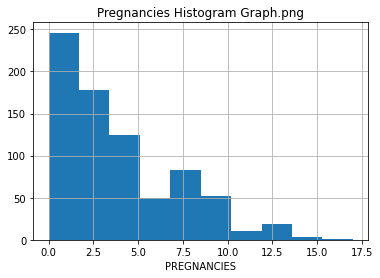

GLUCOSE
count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
20%       95.000000
30%      102.000000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: GLUCOSE, dtype: float64


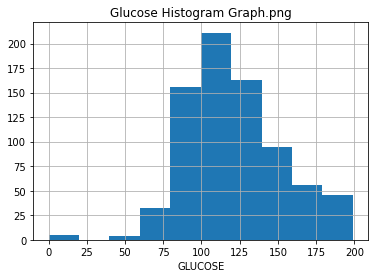

BLOODPRESSURE
count    768.000000
mean      69.105469
std       19.355807
min        0.000000
5%        38.700000
10%       54.000000
20%       60.000000
30%       64.000000
40%       68.000000
50%       72.000000
60%       74.000000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BLOODPRESSURE, dtype: float64


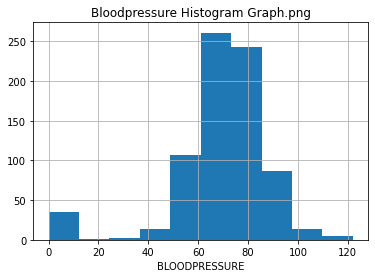

SKINTHICKNESS
count    768.000000
mean      20.536458
std       15.952218
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        8.200000
40%       18.000000
50%       23.000000
60%       27.000000
70%       31.000000
80%       35.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       99.000000
Name: SKINTHICKNESS, dtype: float64


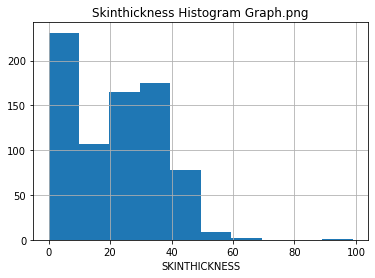

INSULIN
count    768.000000
mean      79.799479
std      115.244002
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%       30.500000
60%       72.200000
70%      106.000000
80%      150.000000
90%      210.000000
95%      293.000000
99%      519.900000
max      846.000000
Name: INSULIN, dtype: float64


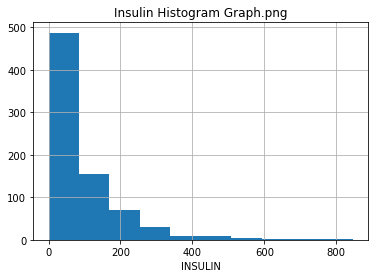

BMI
count    768.000000
mean      31.992578
std        7.884160
min        0.000000
5%        21.800000
10%       23.600000
20%       25.900000
30%       28.200000
40%       30.100000
50%       32.000000
60%       33.700000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64


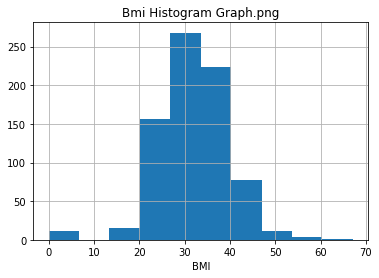

DIABETESPEDIGREEFUNCTION
count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DIABETESPEDIGREEFUNCTION, dtype: float64


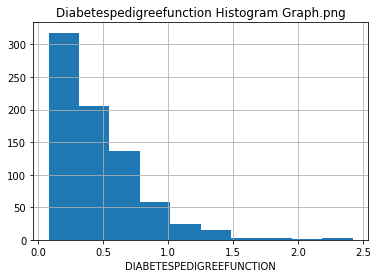

AGE
count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: AGE, dtype: float64


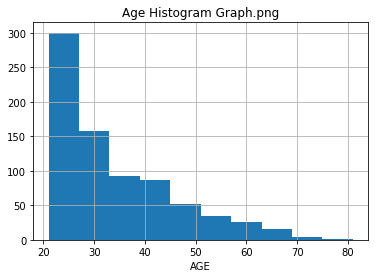

In [10]:
for col in numerical_cols:
    print(col)
    num_summary(df,col,True)

   OUTCOME      Ratio
0      500  65.104167
1      268  34.895833
##########################################


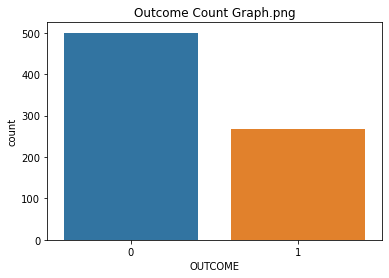

In [11]:
def catSummary(dataframe, colName, plot=False):
    print(pd.DataFrame({colName: dataframe[colName].value_counts(),
                        "Ratio": 100 * dataframe[colName].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[colName], data=dataframe)
        plt.title("{} Count Graph.png".format(colName.capitalize()))
        plt.savefig("{} Count Graph.png".format(colName.capitalize()))
        plt.show(block=True)
    
for col in categorical_cols:
    if df[col].dtypes == "bool":
        print(col)
    else:
        catSummary(df, col, True)

### 3.4 Step 4: Perform target variable analysis. (The mean of the target variable according to the categorical variables, the mean of the numerical variables according to the target variable) 

In [12]:
def targetSummary(dataframe,target,col_name):
    print(dataframe.groupby(target).agg({col_name:"mean"}),end="\n\n\n")

for col in numerical_cols:
    targetSummary(df,"OUTCOME",col)

         PREGNANCIES
OUTCOME             
0           3.298000
1           4.865672


            GLUCOSE
OUTCOME            
0        109.980000
1        141.257463


         BLOODPRESSURE
OUTCOME               
0            68.184000
1            70.824627


         SKINTHICKNESS
OUTCOME               
0            19.664000
1            22.164179


            INSULIN
OUTCOME            
0         68.792000
1        100.335821


               BMI
OUTCOME           
0        30.304200
1        35.142537


         DIABETESPEDIGREEFUNCTION
OUTCOME                          
0                        0.429734
1                        0.550500


               AGE
OUTCOME           
0        31.190000
1        37.067164




### 3.5 Step 5: Perform outlier observation analysis.

#### 3.5.1 Outlier Thresholds

In [13]:
def outlier_thresholds(dataframe, col_name, q1 = 0.25, q3 = 0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + (1.5 * interquartile_range)
    low_limit = quartile1 - (1.5 * interquartile_range)
    return low_limit, up_limit

#### 3.5.2 Check Outliers

In [14]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [15]:
for col in numerical_cols:
    print("{} --> {}".format(col,check_outlier(df,col)))

PREGNANCIES --> True
GLUCOSE --> True
BLOODPRESSURE --> True
SKINTHICKNESS --> True
INSULIN --> True
BMI --> True
DIABETESPEDIGREEFUNCTION --> True
AGE --> True


#### 3.5.3 Accessing Outliers

In [16]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print("If the number of outlier values in data frame is greater than 10 of {} column:".format(str(col_name)))
        display(dataframe[((dataframe[col] < low) | (dataframe[col_name] > up))].head())
    else:
        print("If the number of outlier values in data frame is not greater than 10 of {} column:".format(str(col_name)))
        display(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index
        

In [17]:
for col in numerical_cols:
    grab_outliers(df, col , True)

If the number of outlier values in data frame is not greater than 10 of PREGNANCIES column:


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
88,15,136,70,32,110,37.1,0.153,43,1
159,17,163,72,41,114,40.9,0.817,47,1
298,14,100,78,25,184,36.6,0.412,46,1
455,14,175,62,30,0,33.6,0.212,38,1


If the number of outlier values in data frame is not greater than 10 of GLUCOSE column:


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


If the number of outlier values in data frame is greater than 10 of BLOODPRESSURE column:


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
7,10,115,0,0,0,35.3,0.134,29,0
15,7,100,0,0,0,30.0,0.484,32,1
18,1,103,30,38,83,43.3,0.183,33,0
43,9,171,110,24,240,45.4,0.721,54,1
49,7,105,0,0,0,0.0,0.305,24,0


If the number of outlier values in data frame is not greater than 10 of SKINTHICKNESS column:


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
579,2,197,70,99,0,34.7,0.575,62,1


If the number of outlier values in data frame is greater than 10 of INSULIN column:


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1
54,7,150,66,42,342,34.7,0.718,42,0
111,8,155,62,26,495,34.0,0.543,46,1
139,5,105,72,29,325,36.9,0.159,28,0


If the number of outlier values in data frame is greater than 10 of BMI column:


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
9,8,125,96,0,0,0.0,0.232,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
81,2,74,0,0,0,0.0,0.102,22,0
120,0,162,76,56,100,53.2,0.759,25,1


If the number of outlier values in data frame is greater than 10 of DIABETESPEDIGREEFUNCTION column:


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
4,0,137,40,35,168,43.1,2.288,33,1
12,10,139,80,0,0,27.1,1.441,57,0
39,4,111,72,47,207,37.1,1.390,56,1
45,0,180,66,39,0,42.0,1.893,25,1
58,0,146,82,0,0,40.5,1.781,44,0


If the number of outlier values in data frame is not greater than 10 of AGE column:


,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
123,5,132,80,0,0,26.8,0.186,69,0
363,4,146,78,0,0,38.5,0.520,67,1
453,2,119,0,0,0,19.6,0.832,72,0
459,9,134,74,33,60,25.9,0.460,81,0
489,8,194,80,0,0,26.1,0.551,67,0
537,0,57,60,0,0,21.7,0.735,67,0
666,4,145,82,18,0,32.5,0.235,70,1
674,8,91,82,0,0,35.6,0.587,68,0
684,5,136,82,0,0,0.0,0.640,69,0


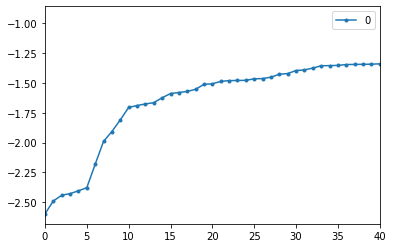

In [18]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)
dfScores = clf.negative_outlier_factor_
scores = pd.DataFrame(np.sort(dfScores))
scores.plot(stacked=True, xlim=[0, 40], style=".-")
plt.show()

### 3.6 Step 6: Perform missing observation analysis.

In [19]:
def missing_values_table(dataframe, na_name=False):
    
    # Column Names with Missing Values
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    # Number of Missing Values of One Column
    number_of_missing_values = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    
    # Percentage Distribution of Missing Data
    percentage_ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    
    # Dataframe with Missing Data
    missing_df = pd.concat([number_of_missing_values, np.round(percentage_ratio, 2)], axis=1, keys=['number_of_missing_values', 'percentage_ratio'])
    
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [20]:
missing_values_table(df)

Empty DataFrame
Columns: [number_of_missing_values, percentage_ratio]
Index: []


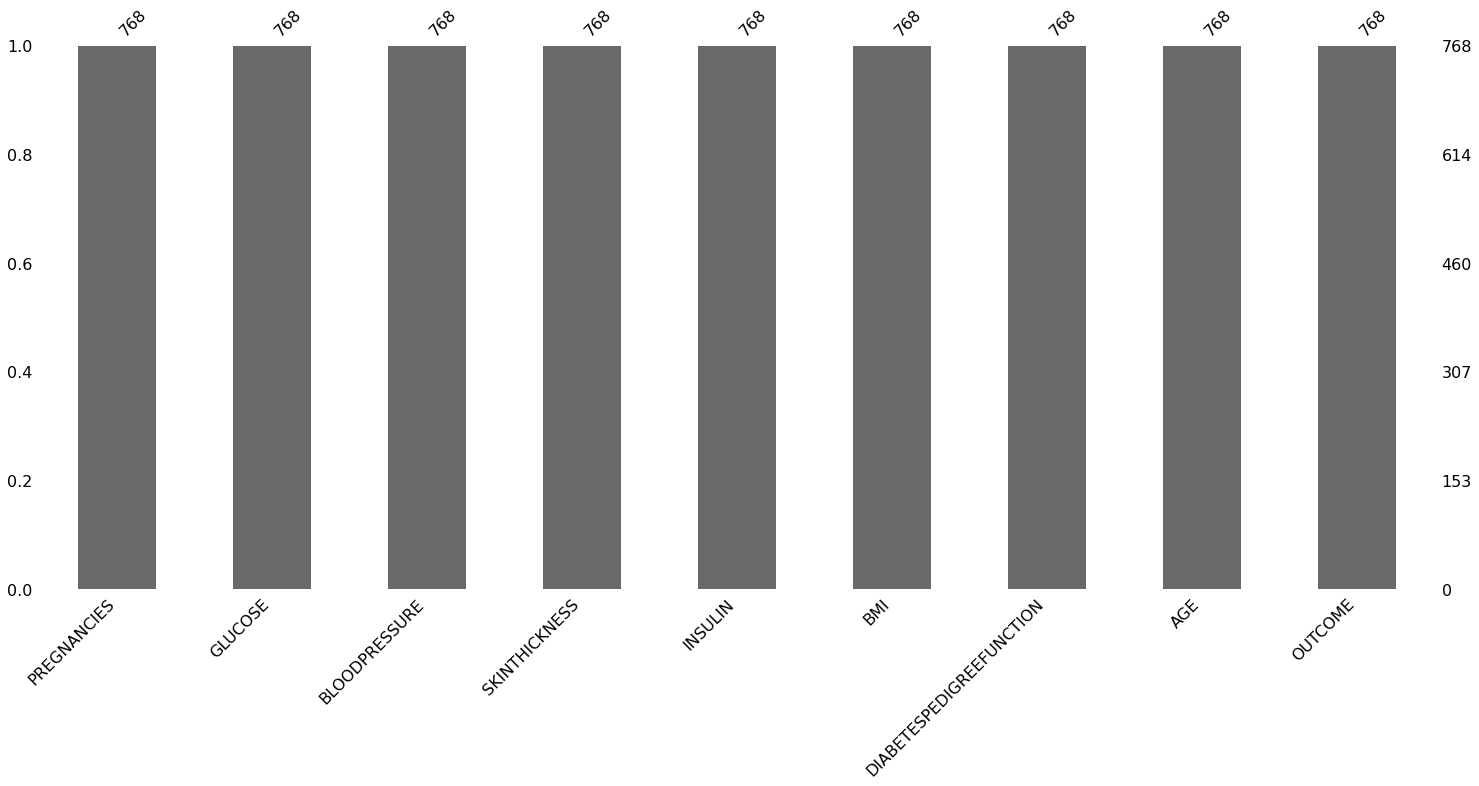

In [21]:
msno.bar(df)
plt.show()

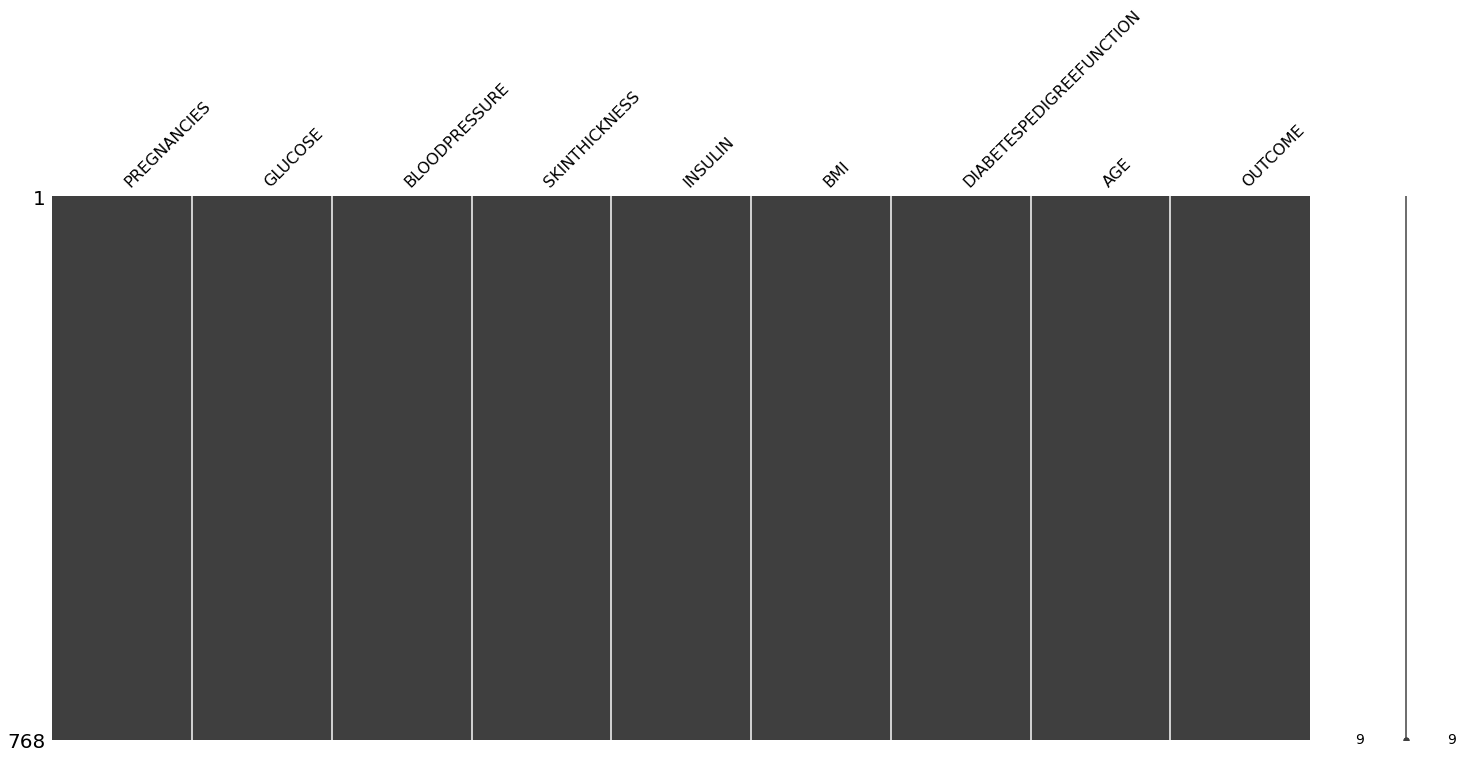

In [22]:
msno.matrix(df)
plt.show()

### 3.7 Step 7: Perform correlation analysis

In [25]:
corr = df[numerical_cols].corr()
corr

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE
PREGNANCIES,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341
GLUCOSE,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514
BLOODPRESSURE,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528
SKINTHICKNESS,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970
INSULIN,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242
DIABETESPEDIGREEFUNCTION,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561
AGE,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000


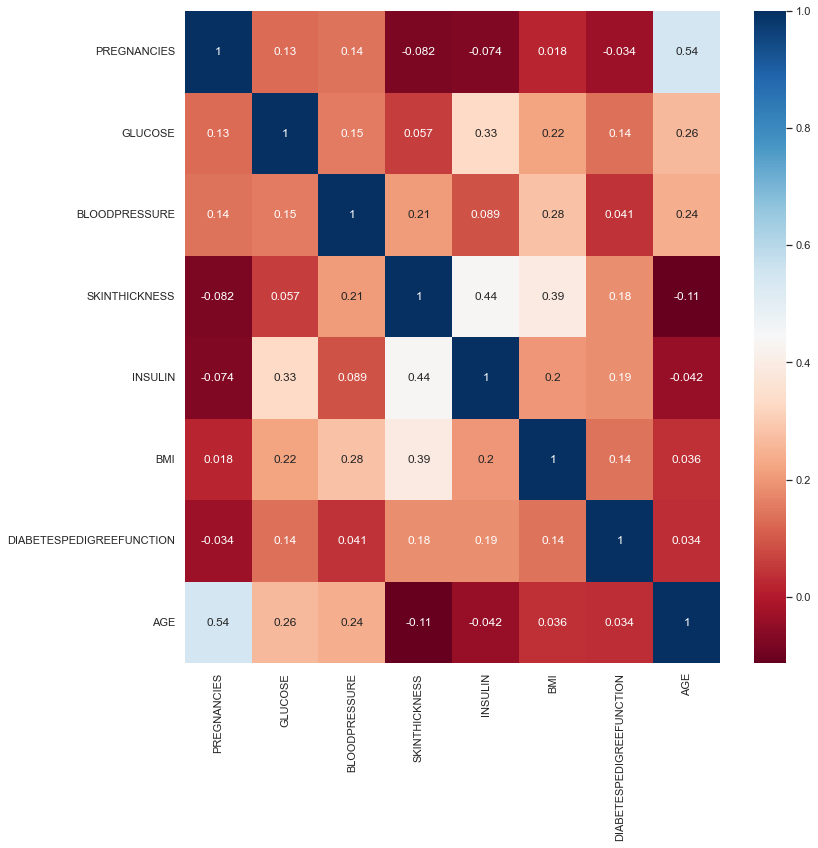

In [26]:
sns.set(rc={"figure.figsize": (12, 12)})
sns.heatmap(corr, cmap="RdBu", annot=True) 
plt.show()

## 4. Feature Engineering

### 4.1 Step 1: Do the necessary procedures for missing and outlier values.

There is no missing observation in the data set, but glucose, Insulin and so on.Observation units containing 0 in variables may express the missing value.For example;A person's glucose or insulin value will not be 0.Taking this situation into consideration, you can assign zero values as nan and then apply the transactions to the missing values.

In [27]:
df.skew(skipna=True)

PREGNANCIES                 0.901674
GLUCOSE                     0.173754
BLOODPRESSURE              -1.843608
SKINTHICKNESS               0.109372
INSULIN                     2.272251
BMI                        -0.428982
DIABETESPEDIGREEFUNCTION    1.919911
AGE                         1.129597
OUTCOME                     0.635017
dtype: float64

In [28]:
df = df.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)
df.isnull().sum()

PREGNANCIES                 0
GLUCOSE                     0
BLOODPRESSURE               0
SKINTHICKNESS               0
INSULIN                     0
BMI                         0
DIABETESPEDIGREEFUNCTION    0
AGE                         0
OUTCOME                     0
dtype: int64

In [31]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

In [29]:
zero_to_nan_columns = ["GLUCOSE","BLOODPRESSURE","SKINTHICKNESS","INSULIN","BMI"]
for col in zero_to_nan_columns:
    df[col] = df[col].replace({"0":np.nan, 0:np.nan})

missing_values_table(df)

               number_of_missing_values  percentage_ratio
INSULIN                             374             48.70
SKINTHICKNESS                       227             29.56
BLOODPRESSURE                        35              4.56
BMI                                  11              1.43
GLUCOSE                               5              0.65


In [32]:
missing_vs_target(df, "OUTCOME",zero_to_nan_columns)

                 TARGET_MEAN  Count
GLUCOSE_NA_FLAG                    
0                   0.348624    763
1                   0.400000      5


                       TARGET_MEAN  Count
BLOODPRESSURE_NA_FLAG                    
0                         0.343793    733
1                         0.457143     35


                       TARGET_MEAN  Count
SKINTHICKNESS_NA_FLAG                    
0                         0.332717    541
1                         0.387665    227


                 TARGET_MEAN  Count
INSULIN_NA_FLAG                    
0                   0.329949    394
1                   0.368984    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0               0.351387    757
1               0.181818     11




#### Replace the low, up limit with Thresholds

In [33]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [35]:
for col in numerical_cols:
    replace_with_thresholds(df, col)
for col in numerical_cols:
    print("{} --> {}".format(col, check_outlier(df,col)))

PREGNANCIES --> False
GLUCOSE --> False
BLOODPRESSURE --> False
SKINTHICKNESS --> False
INSULIN --> False
BMI --> False
DIABETESPEDIGREEFUNCTION --> False
AGE --> False


In [36]:
def imputation_with_mean(df, col_name):
    df[col_name].fillna(df[col_name].mean(), inplace= True)

In [37]:
for col in zero_to_nan_columns:
    imputation_with_mean(df,col)

In [ ]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)
df_scores = clf.negative_outlier_factor_
sorted_df_scores = np.sort(df_scores)
scores = pd.DataFrame(sorted_df_scores)
scores.plot(stacked=True, xlim=[0, 20], style='.-')
plt.show()

### 4.2 Step 2: Create new variables

### 4.3 Step 3: Encoding

### 4.4 Step 4: Standardization for Numerical Variables

### 4.5 Modelling